In [12]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import length, split, size, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

In [13]:
spark = SparkSession.builder.appName("HypothesisTesting").getOrCreate()

hdfs_path = "hdfs://localhost:54310/user/ubuntu/books_dataset/"

df = spark.read.csv(hdfs_path, header=True, inferSchema=True)

df = df.select("star_rating", "review_body").dropna()

df.show(5)


+-----------+--------------------+
|star_rating|         review_body|
+-----------+--------------------+
|        4.0|Unlike many books...|
|        5.0|This book is the ...|
|        5.0|When I started th...|
|        5.0|This book has som...|
|        4.0|This book is a sm...|
+-----------+--------------------+
only showing top 5 rows



In [14]:
# Review length
df = df.withColumn("word_count", size(split(col("review_body"), " ")))

# Lexical diversity (unique/total words)
def lexical_diversity(text):
    words = text.split()
    if len(words) == 0:
        return 0.0
    return len(set(words)) / len(words)

lex_div_udf = udf(lexical_diversity, DoubleType())
df = df.withColumn("lexical_diversity", lex_div_udf(col("review_body")))

df.show(5)


+-----------+--------------------+----------+------------------+
|star_rating|         review_body|word_count| lexical_diversity|
+-----------+--------------------+----------+------------------+
|        4.0|Unlike many books...|       107|0.7850467289719626|
|        5.0|This book is the ...|        81|0.8441558441558441|
|        5.0|When I started th...|       129|0.5317460317460317|
|        5.0|This book has som...|        56|0.8113207547169812|
|        4.0|This book is a sm...|       108|0.7129629629629629|
+-----------+--------------------+----------+------------------+
only showing top 5 rows



In [15]:
# Divide word length and word diversity into groups
grouped_df = df.groupBy("star_rating").agg(
    F.avg("word_count").alias("avg_word_count"),
    F.avg("lexical_diversity").alias("avg_lexical_diversity")
)

grouped_df.show()


+-----------+------------------+---------------------+
|star_rating|    avg_word_count|avg_lexical_diversity|
+-----------+------------------+---------------------+
|        1.0| 159.4943438914027|    0.757366908202626|
|        4.0|193.03222341568207|   0.7255875323141988|
|        3.0|200.86643026004728|    0.719642057291603|
|        2.0|174.48813559322033|   0.7372424089447392|
|        5.0|146.36644895152975|   0.7571991505899387|
+-----------+------------------+---------------------+



In [16]:
# Filter ratings
one_star_df = df.filter(df["star_rating"] == 1)
three_star_df = df.filter(df["star_rating"] == 3)
five_star_df = df.filter(df["star_rating"] == 5)

# Calculate average word length and word diversity for ratings
one_star_word_count = one_star_df.select("word_count").rdd.flatMap(lambda x: x).collect()
three_star_word_count = three_star_df.select("word_count").rdd.flatMap(lambda x: x).collect()
five_star_word_count = five_star_df.select("word_count").rdd.flatMap(lambda x: x).collect()

one_star_lexical_diversity = one_star_df.select("lexical_diversity").rdd.flatMap(lambda x: x).collect()
three_star_lexical_diversity = three_star_df.select("lexical_diversity").rdd.flatMap(lambda x: x).collect()
five_star_lexical_diversity = five_star_df.select("lexical_diversity").rdd.flatMap(lambda x: x).collect()

In [17]:
import scipy.stats as stats

# Word length difference between ratings
t_stat_1_3, p_value_1_3_word_count = stats.ttest_ind(one_star_word_count, three_star_word_count)
t_stat_1_5, p_value_1_5_word_count = stats.ttest_ind(one_star_word_count, five_star_word_count)
t_stat_3_5, p_value_3_5_word_count = stats.ttest_ind(three_star_word_count, five_star_word_count)

# Word diversity difference between ratings
t_stat_1_3_div, p_value_1_3_div = stats.ttest_ind(one_star_lexical_diversity, three_star_lexical_diversity)
t_stat_1_5_div, p_value_1_5_div = stats.ttest_ind(one_star_lexical_diversity, five_star_lexical_diversity)
t_stat_3_5_div, p_value_3_5_div = stats.ttest_ind(three_star_lexical_diversity, five_star_lexical_diversity)

# Results
print(f"t-test p-value for word_count (1 vs 3): {p_value_1_3_word_count}")
print(f"t-test p-value for word_count (1 vs 5): {p_value_1_5_word_count}")
print(f"t-test p-value for word_count (3 vs 5): {p_value_3_5_word_count}")

print(f"t-test p-value for lexical_diversity (1 vs 3): {p_value_1_3_div}")
print(f"t-test p-value for lexical_diversity (1 vs 5): {p_value_1_5_div}")
print(f"t-test p-value for lexical_diversity (3 vs 5): {p_value_3_5_div}")


t-test p-value for word_count (1 vs 3): 5.439479425301659e-07
t-test p-value for word_count (1 vs 5): 0.01330603575191302
t-test p-value for word_count (3 vs 5): 1.8335360370733528e-22
t-test p-value for lexical_diversity (1 vs 3): 7.037612997071968e-13
t-test p-value for lexical_diversity (1 vs 5): 0.9657666235601587
t-test p-value for lexical_diversity (3 vs 5): 4.699088483939013e-21


In [ ]:
#Helpfulness Ratio

In [18]:
reviews_df = spark.read.csv("hdfs://localhost:54310/user/ubuntu/books_dataset/", 
                            header=True, inferSchema=True)

# Avoid division by zero
df = reviews_df.withColumn(
    "helpfulness_ratio",
    F.when(F.col("total_votes") > 0, F.col("helpful_votes") / F.col("total_votes")).otherwise(0)
)

reviews_df.show(5)

+----------+--------------------+-----------+-------------+-----------+--------------------+--------------------+-----------+
|product_id|       product_title|star_rating|helpful_votes|total_votes|     review_headline|         review_body|review_date|
+----------+--------------------+-----------+-------------+-----------+--------------------+--------------------+-----------+
|0312977379|    Beware the Night|        4.0|         61.0|       79.0|A book that actua...|Unlike many books...| 2005-10-13|
|1420832158|JEET KUNE DO: THE...|        5.0|          1.0|        4.0|Something  For Ev...|This book is the ...| 2005-10-13|
|0312977379|    Beware the Night|        5.0|         12.0|       18.0|    Beware the Night|When I started th...| 2005-10-13|
|0312336853|Shooter: The Auto...|        5.0|          1.0|        4.0|Hard to put this ...|This book has som...| 2005-10-13|
|0756607574|             Panties|        4.0|          5.0|       12.0|         A Nice Read|This book is a sm...| 2005

In [19]:
df.groupBy("star_rating").agg(
    F.avg("helpfulness_ratio").alias("avg_helpfulness"),
    F.count("*").alias("n_reviews")
).orderBy("star_rating").show()

df = df.withColumn("review_length", F.length("review_body"))

df.select(
    F.corr("review_length", "helpfulness_ratio").alias("corr_length_helpfulness")
).show()

+-----------+------------------+---------+
|star_rating|   avg_helpfulness|n_reviews|
+-----------+------------------+---------+
|        1.0|0.5232437553223662|      884|
|        2.0|0.5734397707697685|      590|
|        3.0|0.5960579096637704|      846|
|        4.0| 0.652346492112155|     1862|
|        5.0|0.6899920776574328|     5818|
+-----------+------------------+---------+

+-----------------------+
|corr_length_helpfulness|
+-----------------------+
|    0.17551772153715803|
+-----------------------+



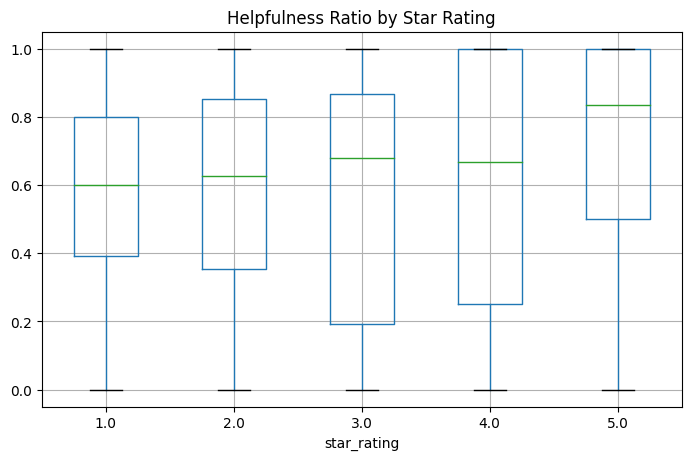

In [20]:
import matplotlib.pyplot as plt

pdf = df.select("star_rating", "helpfulness_ratio").sample(fraction=0.1).toPandas()
pdf.boxplot(column="helpfulness_ratio", by="star_rating", figsize=(8,5))
plt.suptitle("")
plt.title("Helpfulness Ratio by Star Rating")
plt.show()

In [21]:
import pymongo

# MongoDB instance (default port 27017)
client = pymongo.MongoClient("mongodb://localhost:27017/")

# Database and collection
db = client["books_reviews_db"]
collection = db["reviews"]

In [22]:
pdf = df.toPandas()

# Pandas → dict
records = pdf.to_dict(orient="records")

# Insert to MongoDB
collection.insert_many(records)
print(f"Inserted {len(records)} documents into MongoDB")

Inserted 10000 documents into MongoDB
